# LSTM for Named Entity Recognition

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os

In [13]:
import tensorflow as tf
from gensim.models import KeyedVectors
#%matplotlib inline

## Load and preprocess data

https://github.com/dice-group/FOX/tree/master/input/Wikiner

In [14]:
data_file = "aij-wikiner-en-wp3"

# Load data
print("Reading the dataset.....")
with open(data_file, "r", encoding="latin1") as data_handle:
    text = data_handle.readlines()

print(text[1])

Reading the dataset.....
The|DT|I-MISC Oxford|NNP|I-MISC Companion|NNP|I-MISC to|TO|I-MISC Philosophy|NNP|I-MISC says|VBZ|O ,|,|O "|LQU|O there|EX|O is|VBZ|O no|DT|O single|JJ|O defining|VBG|O position|NN|O that|IN|O all|DT|O anarchists|NNS|O hold|VBP|O ,|,|O and|CC|O those|DT|O considered|VBN|O anarchists|NNS|O at|IN|O best|JJS|O share|NN|O a|DT|O certain|JJ|O family|NN|O resemblance|NN|O .|.|O "|RQU|O



In [15]:
text_flat = []
for item in text:
    text_flat.extend(item.split(" "))
print(text_flat[1])

The|DT|I-MISC


In [16]:
text = []
for item in text_flat:
    text.append(item.split("|"))
print(text[1])

['The', 'DT', 'I-MISC']


In [17]:
data = pd.DataFrame(text[0:200000], columns=["Word", "POS", "NER"])
data.drop(["POS"], axis=1, inplace=True)
del text, text_flat

In [18]:
data.head(50)

,Word,NER
0,\n,None
1,The,I-MISC
2,Oxford,I-MISC
3,Companion,I-MISC
4,to,I-MISC
5,Philosophy,I-MISC
6,says,O
7,",",O
8,"""",O
9,there,O


In [19]:
# I get rid of BIO labels and instead use the 4 classes directly
# This is because the data is awfully imbalanced and there
# are barely any B-* classes
classes_map = {
    # Incorrect classes
    "B-ERS": "PERS",
    "B-MSIC": "MISC",
    "B-OEG": "ORG",
    "B-ORF": "ORG",
    "B-PERs": "PERS",
    "B-PRG": "ORG",
    "I-PRG": "ORG",
    "IPERS": "PERS",
    "": "O",
    "o": "O",
    "O\n": "O",
    None: "O",
    "I-MISC\n": "MISC",
    "B-MIS0": "MISC",
    "B-MIS1": "MISC",
    "B-MIS2": "MISC",
    "B-MIS3": "MISC",
    "I-MIS0": "MISC",
    "I-MIS1": "MISC",
    "I-MIS2": "MISC",
    "I-MIS3": "MISC",
    "B-SPANISH": "O",
    "I-SPANISH": "O",
    "B-MIS": "MISC",
    "I-MIS": "MISC",
    "B-MIS-2": "MISC",
    "B-MIS-1": "MISC",
    "B-MIS1'": "MISC",
    "I-MIS": "MISC",
    "I-LOC\n": "LOC",
    "OO": "O",
    "I--ORG": "ORG",
    "I-ORG\n": "ORG",
    "B-MISS1": "MISC",
    "IO": "O",
    "B-ENGLISH": "O",
    "I-PER\n": "PERS",
    "B-PER": "PERS",
    "I-PER": "PERS",
    
    # Correct classes
    "B-LOC": "LOC",
    "O": "O",
    "B-ORG": "ORG",
    "I-ORG": "ORG",
    "B-PERS": "PERS",
    "I-PERS": "PERS",
    "I-LOC": "LOC",
    "I-MISC": "MISC",
    "B-MISC": "MISC",
}

data['NER'] = data['NER'].map(classes_map)


## Plot a histogram of classes

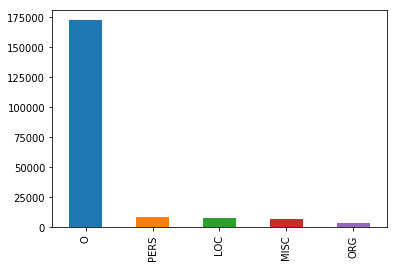

In [20]:
bins = data["NER"].value_counts()
total = data["NER"].count()
bins = bins.apply(lambda x: float(x)/total)

# Histogram of the classes
data["NER"].value_counts().plot(kind="bar")

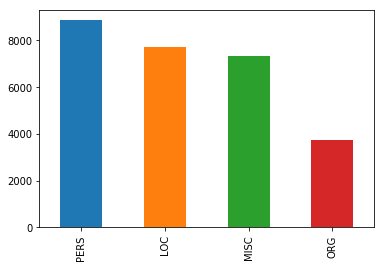

In [21]:
data["NER"].value_counts().drop("O", axis=0).plot(kind='bar')

## Load the word vectors

https://nlp.stanford.edu/projects/glove/

In [22]:
word_vecs = KeyedVectors.load_word2vec_format("glove.txt")

In [23]:
data["Word"] = data["Word"].apply(lambda word: np.array(word_vecs.word_vec(word)).astype(np.float16) if word in word_vecs else np.zeros((200)))

In [24]:
data["Word"].head(10)

0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4    [0.6177, 0.2104, 0.527, 0.2047, 0.257, -0.2173...
5    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6    [0.1035, 0.10205, 0.0892, 0.1975, -0.5728, -0....
7    [0.3926, -0.08417, -0.6074, 0.323, -0.3591, 0....
8    [0.2751, 0.3997, 0.06854, -0.00705, -0.2837, 0...
9    [-0.04156, 0.2177, -0.09796, 0.1228, -0.1597, ...
Name: Word, dtype: object

## Class encoding

In [25]:
le = LabelEncoder()
le.fit(data["NER"].unique())


data["NER"] = data["NER"].apply(lambda x: le.transform([[x]])[0])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Now we need to turn data into sequences

In [26]:
def window_stack(X, Y, stride=1, time_steps=3, output_mode=0):
    """Stacks elements in a window and resizes array to be array of
       sequences."""

    # Output_mode defines if it will return sequence of Y or a
    # single Y value corresponding to a sequence of X
    # 0 => Single, 1 => Sequence

    if(len(Y) == 0):
        test = True
    else:
        test = False

    X2 = X[np.arange(0, X.shape[0]-time_steps+1, stride)[:,None] + np.arange(time_steps)]
    
    if(not test):
        Y2 = Y[np.arange(0, Y.shape[0]-time_steps+1, stride)[:,None] + np.arange(time_steps)]
        return (X2, Y2)

    return X2

SEQ_LENGTH = 10

X = data["Word"]
Y = data["NER"]

X = np.array([np.array(item) for item in X.values])
Y = np.array([np.array(item) for item in Y.values])

# Turn the data into sequences
X, Y = window_stack(X, Y, time_steps=SEQ_LENGTH, output_mode=1, stride=SEQ_LENGTH)
X[0], Y[0]

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.39257812, -0.08416748, -0.60742188, ...,  0.09387207,
         -0.58496094,  0.19543457],
        [ 0.27514648,  0.3996582 ,  0.06854248, ..., -0.2565918 ,
         -0.19763184,  0.32202148],
        [-0.04156494,  0.21765137, -0.09796143, ...,  0.44311523,
          0.08898926, -0.01033783]]), array([2, 1, 1, 1, 1, 1, 2, 2, 2, 2]))

In [27]:
X[0].shape, Y[0].shape

((10, 200), (10,))

## Train test split

In [28]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.4)
X_Train, X_Val, Y_Train, Y_Val = train_test_split(X_Train, Y_Train, test_size=0.3)

In [29]:
X_Train[0], Y_Train[0]

(array([[ 0.14929199,  0.27880859,  0.08996582, ..., -0.44824219,
          0.31591797, -0.49365234],
        [ 0.17028809,  0.06768799, -0.10314941, ...,  0.46118164,
          0.62109375,  0.23791504],
        [-0.05422974,  0.56787109,  0.17700195, ..., -0.04641724,
          0.33032227,  0.1920166 ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.31176758, -0.04629517, -0.12817383, ..., -0.74951172,
         -0.51171875,  0.20959473]]), array([2, 2, 2, 2, 2, 2, 0, 0, 0, 2]))

In [30]:
print("Training set shapes: {} {}".format(X_Train.shape, Y_Train.shape))
print("Validation set shapes: {} {}".format(X_Val.shape, Y_Val.shape))
print("Test set shapes: {} {}".format(X_Test.shape, Y_Test.shape))

Training set shapes: (8400, 10, 200) (8400, 10)
Validation set shapes: (3600, 10, 200) (3600, 10)
Test set shapes: (8000, 10, 200) (8000, 10)


## Change dtype to float32

In [31]:
X_Train = X_Train.astype(np.float32)
X_Test = X_Test.astype(np.float32)
X_Val = X_Val.astype(np.float32)

## Create iterators

In [66]:
train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X_Train), tf.data.Dataset.from_tensor_slices(Y_Train)))
test = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X_Test), tf.data.Dataset.from_tensor_slices(Y_Test)))
val = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X_Val), tf.data.Dataset.from_tensor_slices(Y_Val)))

train = train.shuffle(buffer_size=1024).batch(64).prefetch(2)
test = test.shuffle(buffer_size=1024).batch(64).prefetch(2)
val = val.shuffle(buffer_size=1024).batch(64).prefetch(2)

with tf.device("/cpu:0"), tf.name_scope("data"):
    iterator = tf.data.Iterator.from_structure(train.output_types,
                                           train.output_shapes)
    train_iterator = iterator.make_initializer(train)
    test_iterator = iterator.make_initializer(test)
    val_iterator = iterator.make_initializer(val)
    
    sequence, labels = iterator.get_next()

## Define the network

In [67]:
with tf.name_scope("LSTM"):
    lstm_cell_forward = tf.nn.rnn_cell.LSTMCell(128, initializer=tf.glorot_uniform_initializer())
    lstm_cell_forward = tf.nn.rnn_cell.DropoutWrapper(lstm_cell_forward, input_keep_prob=0.2, output_keep_prob=0.2, state_keep_prob=0.2)
    
    lstm_cell_backward = tf.nn.rnn_cell.LSTMCell(128, initializer=tf.glorot_uniform_initializer())
    lstm_cell_backward = tf.nn.rnn_cell.DropoutWrapper(lstm_cell_backward, input_keep_prob=0.2, output_keep_prob=0.2, state_keep_prob=0.2)
    
    (forward_seq, backward_seq), _ = tf.nn.bidirectional_dynamic_rnn(
        cell_fw = lstm_cell_forward,
        cell_bw = lstm_cell_backward,
        inputs=sequence,
        dtype=tf.float32
    )
    output = tf.concat([forward_seq, backward_seq], axis=-1)

In [68]:
classes = len(data["NER"].unique())
with tf.name_scope("Projection"):
        W = tf.get_variable(name="W",
                            shape=[256, classes],
                            initializer=tf.glorot_uniform_initializer(),
                            dtype=tf.float32)

        b = tf.get_variable(name="b",
                            shape=[classes],
                            initializer=tf.zeros_initializer(),
                            dtype=tf.float32)
        scores = tf.tensordot(output, W, 1) + b

In [69]:
with tf.name_scope("CRF"):
    sequence_lengths = SEQ_LENGTH * tf.ones((tf.shape(sequence)[0]), dtype=tf.int32)
    log_likelihood, transition_params = tf.contrib.crf.crf_log_likelihood(
        scores, labels, sequence_lengths)
    viterbi_sequence, viterbi_score = tf.contrib.crf.crf_decode(
        scores, transition_params, sequence_lengths)

    loss = tf.reduce_mean(-log_likelihood)

In [70]:
with tf.name_scope("Optimizer"):
    adam = tf.train.AdamOptimizer(learning_rate=0.001)
    optimizer = adam.minimize(loss)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [71]:
def liveTest(text):
    text_tokens = text.split(" ")
    text_vectors = []
    for word in text_tokens:
        text_vectors.append(np.array(word_vecs.word_vec(word)).astype(np.float16) if word in word_vecs else np.zeros((200)))
    if(len(text_vectors) < 10):
        for i in range(10 - len(text_vectors)):
            text_vectors.append(np.zeros((200)))
    text_vectors = np.array([text_vectors])
    live = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(text_vectors.astype(np.float32)), tf.data.Dataset.from_tensor_slices(np.zeros((1, 10)).astype(np.int64))))
    live = live.batch(1).prefetch(1)
    with tf.device("/cpu:0"), tf.name_scope("data"):
        live_iterator = iterator.make_initializer(live)
    sess.run(live_iterator)
    viterbi = sess.run(viterbi_sequence)[0, 0:len(text_tokens)]
    viterbi_decoded = []
    for tag, token in zip(viterbi, text_tokens):
        viterbi_decoded.append(token + "   =>   " + le.inverse_transform(tag))
    return viterbi_decoded

In [72]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(50):
        sess.run(train_iterator)
        try:
            total_loss = []
            while True:
                _, l = sess.run([optimizer, loss])
                total_loss.append(l)
        except tf.errors.OutOfRangeError as e:
            pass

        # Calculate epoch loss
        total_loss = np.mean(total_loss)
        print("Epoch {}: Loss {} ".format(i, total_loss))
        print(liveTest("My name is John Doe"))
        save_path = saver.save(sess, "./model.ckpt")

Epoch 0: Loss 5.419626235961914 
['My   =>   O', 'name   =>   O', 'is   =>   O', 'John   =>   O', 'Doe   =>   O']
Epoch 1: Loss 4.066124439239502 
['My   =>   PERS', 'name   =>   O', 'is   =>   O', 'John   =>   MISC', 'Doe   =>   MISC']
Epoch 2: Loss 3.676591396331787 
['My   =>   O', 'name   =>   O', 'is   =>   O', 'John   =>   MISC', 'Doe   =>   MISC']
Epoch 3: Loss 3.4844770431518555 
['My   =>   O', 'name   =>   O', 'is   =>   O', 'John   =>   O', 'Doe   =>   MISC']
Epoch 4: Loss 3.3027689456939697 
['My   =>   PERS', 'name   =>   O', 'is   =>   O', 'John   =>   MISC', 'Doe   =>   MISC']
Epoch 5: Loss 3.1602630615234375 
['My   =>   O', 'name   =>   O', 'is   =>   O', 'John   =>   MISC', 'Doe   =>   MISC']
Epoch 6: Loss 3.0605509281158447 
['My   =>   PERS', 'name   =>   O', 'is   =>   O', 'John   =>   O', 'Doe   =>   O']
Epoch 7: Loss 2.987633466720581 
['My   =>   PERS', 'name   =>   O', 'is   =>   O', 'John   =>   MISC', 'Doe   =>   MISC']
Epoch 8: Loss 2.9062952995300293 
['My 